# Classical AE on MNIST


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses

import warnings
warnings.filterwarnings('ignore')

2022-06-28 18:46:16.783482: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 18:46:16.783513: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-28 18:46:19.015586: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-28 18:46:19.015622: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-28 18:46:19.015646: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-06-28 18:46:19.015975: I tensorflow/core/platform/cpu_fe

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0
print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (60000, 28, 28)
x_test:  (10000, 28, 28)
y_train:  (60000,)
y_test:  (10000,)


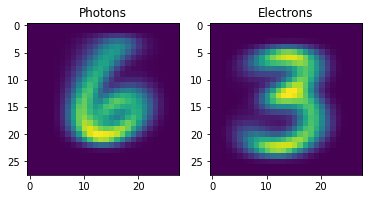

In [3]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_train[y_train==6],0))
axs[0].title.set_text('Photons')

axs[1].imshow(np.average(x_train[y_train==3],0))
axs[1].title.set_text('Electrons')

In [4]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [5]:
x_train = x_train.reshape(-1, x_train.shape[-1]*x_train.shape[-2])
x_test = x_test.reshape(-1, x_test.shape[-1]*x_test.shape[-2])

In [6]:
num_data, input_dim = x_train.shape

In [7]:
latent_dim = 6
ae = cae.Autoencoder(input_dim, latent_dim)

In [8]:
ae.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.05))

In [9]:
ae.build(x_train.shape)
ae.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 6)                 4710      
                                                                 
 sequential_1 (Sequential)   (12049, 784)              5488      
                                                                 
Total params: 10,198
Trainable params: 10,198
Non-trainable params: 0
_________________________________________________________________


In [10]:
ae.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 4710      
                                                                 
Total params: 4,710
Trainable params: 4,710
Non-trainable params: 0
_________________________________________________________________


In [11]:
ae.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (12049, 784)              5488      
                                                                 
Total params: 5,488
Trainable params: 5,488
Non-trainable params: 0
_________________________________________________________________


In [12]:
x_train_three = x_train[y_train==1]
x_train = x_train[y_train==0]

x_test_three = x_test[y_test==1]
x_test = x_test[y_test==0]

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
hist = ae.fit(x_train, x_train,
                epochs=40,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[es])

Epoch 1/40
185/185 [==============================] - 1s 3ms/step - loss: 0.0469 - val_loss: 0.0395
Epoch 2/40
185/185 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0372
Epoch 3/40
185/185 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0365
Epoch 4/40
185/185 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0380
Epoch 5/40
185/185 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0365
Epoch 6/40
185/185 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0368
Epoch 7/40
185/185 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0368
Epoch 8/40
185/185 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0367
Epoch 9/40
185/185 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0372
Epoch 10/40
185/185 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0365

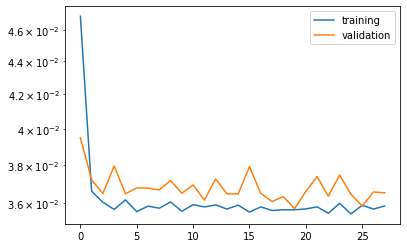

In [14]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

In [15]:
def mae(x):
    pred = ae.predict(x)
    return np.mean(np.abs(x - pred)**2,axis=1)

def recon_acc(x):
    return 1 - mae(x)

In [16]:
sixes = recon_acc(x_test)
threes = recon_acc(x_test_three)

0.9663142214856256
0.9033535656681279


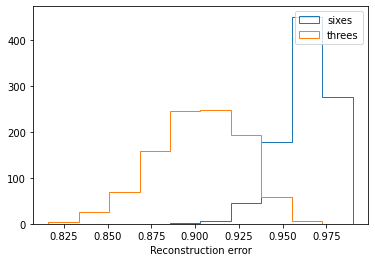

In [19]:
print(np.median(sixes))
bins = np.histogram(np.hstack((sixes, threes)), bins=10)[1]
plt.hist(sixes, histtype='step', label="sixes",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(threes))
plt.hist(threes, histtype='step', label="threes",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.xlabel("Reconstruction error")
plt.legend()

0.9410569105691057


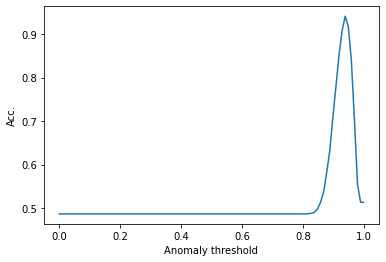

In [20]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(sixes > T)
    # threes that are predicted three
    num_three_right = np.sum(threes < T)
    acc = (num_six_right + num_three_right)/(len(sixes) + len(threes))
    return acc

Ts = np.linspace(0,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
print(max(accs))
plt.xlabel("Anomaly threshold")
plt.ylabel("Acc.")
plt.plot(Ts, accs)  